# Прогнозирование трафика автомагистрали на основе временных и погодных факторов


#### Подключение библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.forecasting.theta import ThetaModel
import statsmodels.api as sm

In [2]:
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
data = data[["date_time", "holiday", "temp", "traffic_volume"]]
data

,date_time,holiday,temp,traffic_volume
0,2012-10-02 09:00:00,None,288.28,5545
1,2012-10-02 10:00:00,None,289.36,4516
2,2012-10-02 11:00:00,None,289.58,4767
3,2012-10-02 12:00:00,None,290.13,5026
4,2012-10-02 13:00:00,None,291.14,4918
...,...,...,...,...
48199,2018-09-30 19:00:00,None,283.45,3543
48200,2018-09-30 20:00:00,None,282.76,2781
48201,2018-09-30 21:00:00,None,282.73,2159
48202,2018-09-30 22:00:00,None,282.09,1450


## EDA & Preproccesing

В датасете **"Metro Interstate Traffic Volume"** содержатся почасовые данные о потоке автомобилей на **межштатной автомагистрали I-94** в западном направлении в районе **Миннеаполиса и Сент-Пола (Миннесота, США)** за **2012–2018 годы**.  

#### **Основные параметры для анализа:**  
- **Дата и время (`date_time`)** – временная метка записи.  
- **Температура (`temp`)** – в Кельвинах (K).  
- **Праздники (`holiday`)** – информация о праздничных днях.  
- **Объем трафика (`traffic_volume`)** – целевая переменная, количество автомобилей в час.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_time       48204 non-null  object 
 1   holiday         48204 non-null  object 
 2   temp            48204 non-null  float64
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


Пропусков нет, выявим дубликаты (если они есть)

In [4]:
data.duplicated().sum()

7551

*Удалим дубликаты*

In [5]:
data.drop_duplicates(inplace=True)
print(f"Осталось записей: {data.shape[0]}")

Осталось записей: 40653


### Проанализируем значения температуры

In [6]:
data[["temp"]].describe()

,temp
count,40653.000000
mean,281.319065
std,13.820109
min,0.000000
25%,271.840000
50%,282.870000
75%,292.290000
max,310.070000


##### Выявление аномальных значений температуры  

Температура измеряется в **Кельвинах (K)**. Для Миннесоты в 2012–2018 гг. разумные границы:  

- **Нижний порог**: **232 K (-41°C)** – температуры ниже маловероятны.  
- **Верхний порог**: **315 K (42°C)** – выше этого значения температура в регионе встречается редко.  

Значения за пределами этих границ могут быть аномальными.  

Источник: [Климат Миннесоты](https://translated.turbopages.org/proxy_u/en-ru.ru.e0d58930-67d69e4f-e8d79975-74722d776562/https/en.wikipedia.org/wiki/Climate_of_Minnesota)

In [7]:
# Определим границы температуры для Миннесоты
temp_lower_bound = 232  # -41°C
temp_upper_bound = 315  # 42°C

# Условие для определения аномалий
temp_outlier_condition = (data["temp"] < temp_lower_bound) | (data["temp"] > temp_upper_bound)


# Выявим аномальные значения
anomalies = data[temp_outlier_condition]
print(f"Количество аномалий: {anomalies.shape[0]}")

Количество аномалий: 10


*Удалим выбросы*

In [8]:
data = data.loc[~temp_outlier_condition, :]
print(f"Осталось записей: {data.shape[0]}")

Осталось записей: 40643


### Посмотрим на распределение праздников

In [9]:
data[["holiday"]].value_counts()

holiday                  
None                         40590
Christmas Day                    5
Columbus Day                     5
Independence Day                 5
Labor Day                        5
Memorial Day                     5
New Years Day                    5
State Fair                       5
Thanksgiving Day                 5
Veterans Day                     5
Washingtons Birthday             5
Martin Luther King Jr Day        3
dtype: int64

Преобразуем признак в новую переменную **`is_holiday`**, которая будет содержать:  

- `1`, если день является праздником.  
- `0`, если день не является праздником.  

In [10]:
data = data.copy()
data["is_holiday"] = (data["holiday"] != "None").astype(int)

# Удалим предыдущий признак
data = data.drop(columns="holiday")

data = data[["date_time", "is_holiday", "temp", "traffic_volume"]]

# Проверим результат
data[["is_holiday"]].value_counts()

is_holiday
0             40590
1                53
dtype: int64

### Анализ и обработка переменной, хранящей временные метки

Для корректного анализа временного ряда необходимо убедиться, что временные интервалы **равномерны**.

In [11]:
duplicates = data["date_time"].duplicated().sum()
print(f"Количество дубликатов в date_time: {duplicates}")

Количество дубликатов в date_time: 78


In [12]:
data.drop_duplicates(subset="date_time", inplace=True)
print(f"Осталось записей: {data.shape[0]}")

Осталось записей: 40565


In [13]:
data["date_time"] = pd.to_datetime(data["date_time"])

data = data.sort_values("date_time")  # Отсортируем датасет по времени

original_data = data.copy()  # Сохраним исходный набор

# Вычислим разницу во времени между соседними значениями (в часах)
data["time_diff"] = data["date_time"].diff().dt.total_seconds() / 3600  # В часах

# Выводим строки, где разница не равна 1 часу
gaps = data[data["time_diff"] != 1]
print(gaps[["date_time", "time_diff"]])

data.drop(columns="time_diff", inplace=True)

                date_time  time_diff
0     2012-10-02 09:00:00        NaN
22    2012-10-03 08:00:00        2.0
24    2012-10-03 12:00:00        3.0
29    2012-10-03 18:00:00        2.0
61    2012-10-05 03:00:00        2.0
...                   ...        ...
42727 2018-03-29 03:00:00        2.0
43821 2018-05-05 03:00:00        2.0
44609 2018-06-02 03:00:00        2.0
46506 2018-08-07 10:00:00        4.0
46938 2018-08-23 03:00:00        2.0

[2591 rows x 2 columns]


##### Заполним пропущенные значения с помощью линейной интерполяции (на основе соседних значений):

Если есть два известных значения (**A**, **B**), интерполяция находит промежуточные точки с помощью следующей формулы:

$x_{\text{interp}} = A + \frac{(B - A)}{\text{количество шагов}} \times \text{номер текущего шага}$

Где:  
- **A** – известное значение перед пропуском.  
- **B** – известное значение после пропуска.  
- **Количество шагов** – число интерполируемых точек между A и B.  
- **Номер текущего шага** – порядковый номер точки внутри пропуска.  

Линейная интерполяция равномерно распределяет недостающие значения между A и B.

In [14]:
# Создадим полный временной диапазон с шагом 1 час
full_range = pd.date_range(start=data["date_time"].min(), end=data["date_time"].max(), freq="H")

data = data.set_index("date_time").reindex(full_range)

# Заполним пропуски NaN с помощью интерполяции
data[["traffic_volume", "temp"]] = data[["traffic_volume", "temp"]].interpolate(method="linear")

data = data.reset_index().rename(columns={"index": "date_time"})

print(f"Оставшиеся пропуски после обработки: {data.isna().sum().sum()}")
print(f"Стало записей: {data.shape[0]}")

Оставшиеся пропуски после обработки: 11986
Стало записей: 52551


In [15]:
# Определим уникальные даты, которые являются праздниками
holiday_dates = data.loc[data["is_holiday"] == 1, "date_time"].dt.date.unique()

# Функция для определения праздника
def is_holiday(date_time):
    return 1 if date_time.date() in holiday_dates else 0

# Применим функцию ко всем строкам
data["is_holiday"] = data["date_time"].apply(is_holiday)
data["is_holiday"].value_counts()

0    51279
1     1272
Name: is_holiday, dtype: int64

Сравним распределение целевой переменной **`traffic_volume`** до и после обработки пропусков с помощью **Boxplot**.<br/>
Это позволит оценить **влияние интерполяции** на распределение данных и убедиться,<br/>
что обработка пропусков **не привела к значительным искажениям**.

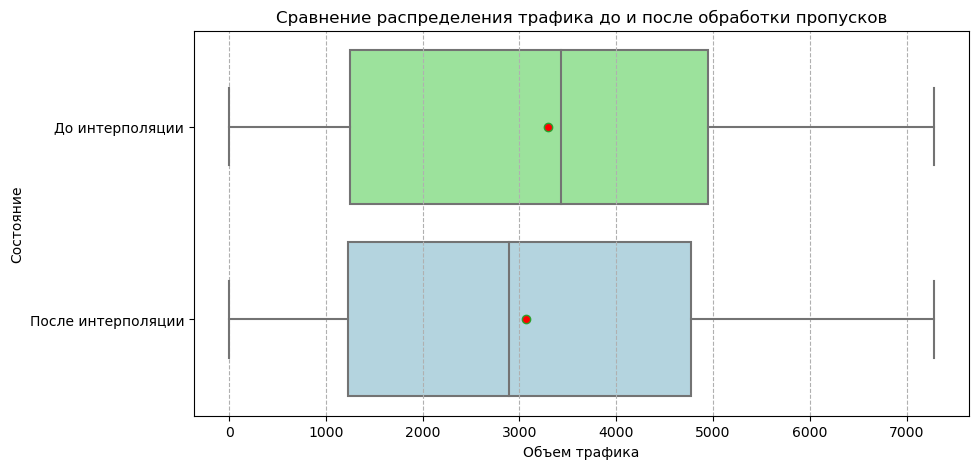

In [16]:
boxplot_data = pd.DataFrame({
    "До интерполяции": original_data["traffic_volume"],
    "После интерполяции": data["traffic_volume"]
}).melt(var_name="Состояние", value_name="traffic_volume")

plt.figure(figsize=(10, 5))
sns.boxplot(x="traffic_volume", y="Состояние", data=boxplot_data, showmeans=True, 
            meanprops={"marker": "o", "markerfacecolor": "red"},
            palette=["lightgreen", "lightblue"])

plt.title("Сравнение распределения трафика до и после обработки пропусков")
plt.xlabel("Объем трафика")
plt.grid(axis="x", linestyle="--")
plt.show()

Видно, что основные статистические характеристики (медиана, среднее, размах)<br/>не изменились значительно
➡ **интерполяция не внесла сильных искажений**.

### Анализ временного ряда

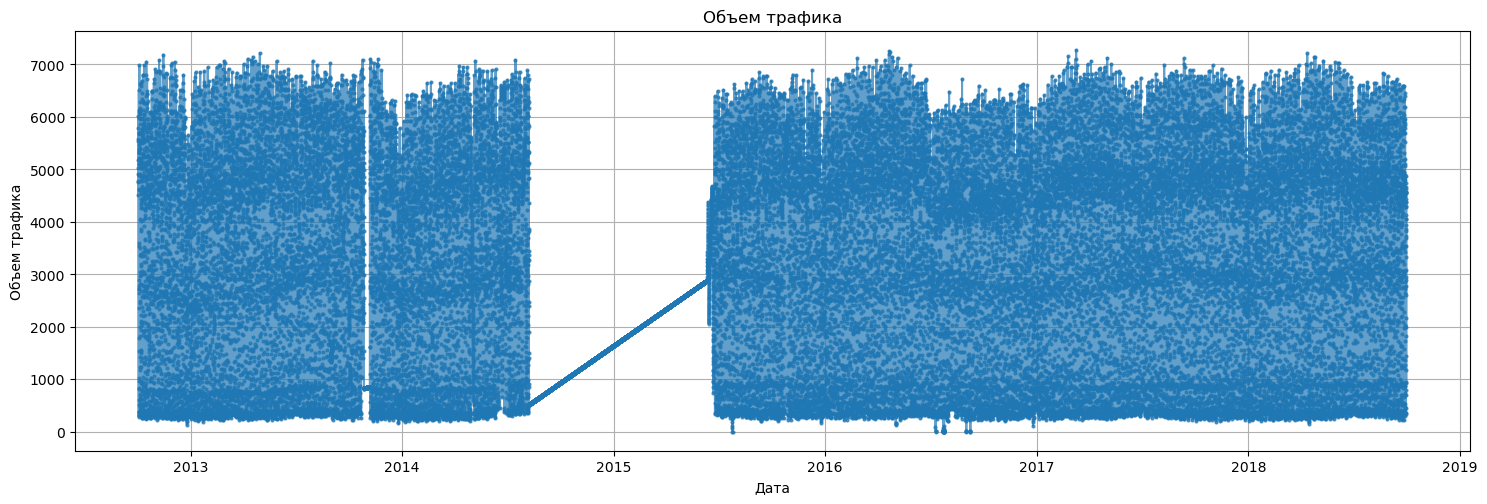

In [17]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plt.plot(data["date_time"], data["traffic_volume"], marker='o',
         markersize=2, alpha=0.7)
plt.title("Объем трафика")
plt.xlabel("Дата")
plt.ylabel("Объем трафика")
plt.grid(True)

На графике видно, что **в период 2014-2015 г. произошло резкое изменение тренда**, после которого данные стабилизировались. <br/>Для построения моделей оставим данные начиная с августа 2015 года.

In [18]:
data = data[data["date_time"] >= "2015-07-01"]
print(f"Количество строк после фильтрации: {data.shape[0]}")
data.head()

Количество строк после фильтрации: 28512


,date_time,is_holiday,temp,traffic_volume
24039,2015-07-01 00:00:00,0,289.20,737.0
24040,2015-07-01 01:00:00,0,289.40,444.0
24041,2015-07-01 02:00:00,0,289.19,347.0
24042,2015-07-01 03:00:00,0,288.74,356.0
24043,2015-07-01 04:00:00,0,288.07,936.0


*Отобразим временной ряд за последнюю неделю и месяц*

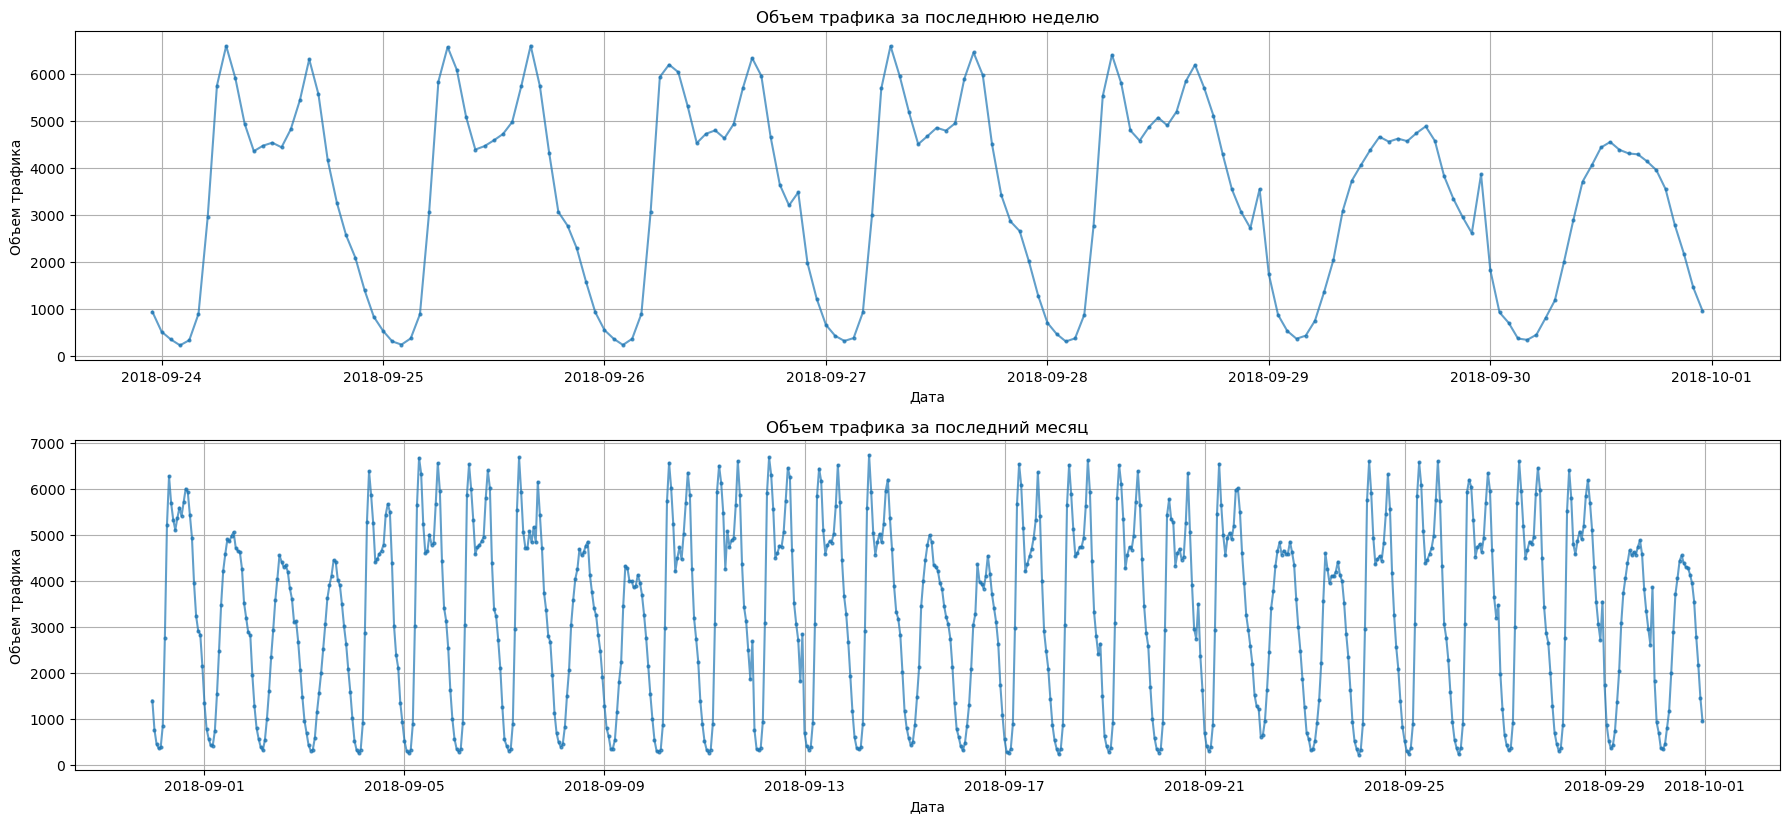

In [19]:
last_date = data["date_time"].max()

# Отфильтруем данные за последнюю неделю и месяц
week_ago = last_date - pd.DateOffset(weeks=1)
month_ago = last_date - pd.DateOffset(months=1)

data_week = data[data["date_time"] >= week_ago]
data_month = data[data["date_time"] >= month_ago]


plt.figure(figsize=(18, 12))

# Объем трафика за последнюю неделю
plt.subplot(3, 1, 1)
plt.plot(data_week["date_time"], data_week["traffic_volume"], marker='o', markersize=2, alpha=0.7)
plt.title("Объем трафика за последнюю неделю")
plt.xlabel("Дата")
plt.ylabel("Объем трафика")
plt.grid(True)

# Объем трафика за последний месяц
plt.subplot(3, 1, 2)
plt.plot(data_month["date_time"], data_month["traffic_volume"], marker='o', markersize=2, alpha=0.7)
plt.title("Объем трафика за последний месяц")
plt.xlabel("Дата")
plt.ylabel("Объем трафика")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Анализ сезонности трафика  

На графиках видно, что трафик демонстрирует **четко выраженные сезонности**:  

- **Суточная сезонность**  
   - Наблюдаются повторяющиеся циклы в течение суток.  
   - В часы пик (утро, вечер) трафик возрастает, ночью снижается.  

- **Недельная сезонность**  
   - В течение недели также есть колебания:  
     - В рабочие дни трафик выше (особенно утром и вечером).  
     - В выходные дни нагрузка на дороги снижается.  
     
<hr style="border: 1px solid gray;">

#### **Анализ ACF и PACF для выбора параметров модели**  

**Автокорреляционная функция (ACF)** и **частичная автокорреляционная функция (PACF)** помогают выявить **зависимости между наблюдениями** во временном ряде.  

- **ACF (Autocorrelation Function)** показывает, насколько текущие значения связаны с прошлыми на разных лагах.  
Если видны **чёткие пики через определённое количество шагов**, это может указывать на **сезонность**.  

- **PACF (Partial Autocorrelation Function)** показывает **чистую зависимость** между текущим и лаговым значением, исключая влияние промежуточных лагов.  
Если PACF быстро затухает, это означает, что модель может использовать **AR(p)** с небольшим числом лагов.  

**Как интерпретировать?**  
- **Пики в ACF → возможная сезонность** (например, через 168 лагов – недельный цикл).  
- **PACF показывает, сколько предыдущих значений напрямую влияет на текущее.**  
- **Если ACF медленно затухает, а PACF имеет резкие скачки, в данных может быть тренд или изменение режима.**  

C:\Users\Silischev\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


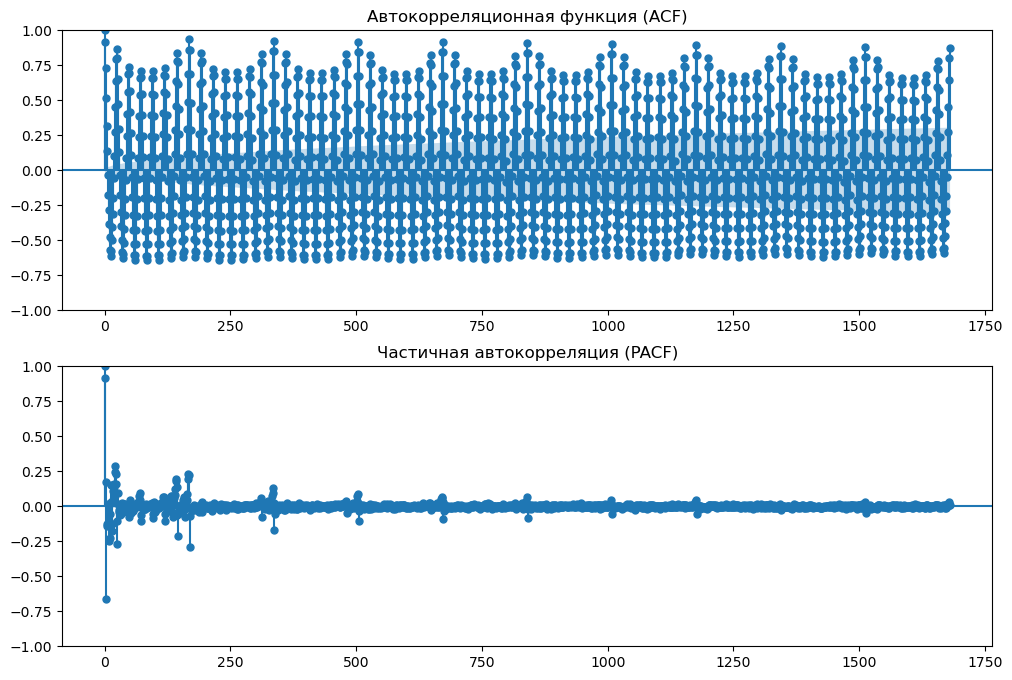

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(data["traffic_volume"], lags=24*7*10, ax=axes[0])  # ACF
axes[0].set_title("Автокорреляционная функция (ACF)")

sm.graphics.tsa.plot_pacf(data["traffic_volume"], lags=24*7*10, ax=axes[1])  # PACF
axes[1].set_title("Частичная автокорреляция (PACF)")

plt.show()

Так как **сезонность проявляется** даже **на более длинных интервалах** (колебания PACF), нежели 1 неделя $ \Rightarrow $<br>попробуем при обучении моделей в качестве параметра указать 1, 2, 3 и 4-х недельные периоды сезонности

### Feature Engineering

In [21]:
data["hour"] = data["date_time"].dt.hour  # Час
data["weekday"] = data["date_time"].dt.weekday  # Недель недели
data["is_weekend"] = data["weekday"].apply(lambda x: 1 if x > 4 else 0)  # Является ли выходным

## Моделирование

### Разделение на train и test

In [22]:
# В качестве test берем данные за последние 2 недели
test_start_date = last_date - pd.DateOffset(weeks=2)

train_data = data[data["date_time"] < test_start_date].copy()
test_data = data[data["date_time"] >= test_start_date].copy()

### Построение и оценка baseline-модели

In [23]:
# Строим baseline-прогноз: среднее значение по часам и дням недели
baseline_forecast = train_data.groupby(["weekday", "hour"])["traffic_volume"].mean()

# Применим прогноз на тестовые данные
test_data["baseline_prediction"] = test_data.apply(
    lambda row: baseline_forecast.loc[row["weekday"], row["hour"]], axis=1
)

Помимо **MAE** и **RMSE**, используем **MAPE (Mean Absolute Percentage Error)** — среднюю абсолютную процентную ошибку:

$$
MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

Преимущества MAPE:
- Показывает ошибку **в процентах**, удобно сравнивать модели.  
- Нормализует ошибку, подходит для данных разного масштаба.  

**Минус**: не работает при **нулевых значениях**.  

In [24]:
# Функция для вычисления MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(test_data["traffic_volume"], test_data["baseline_prediction"])
rmse = np.sqrt(mean_squared_error(test_data["traffic_volume"], test_data["baseline_prediction"]))
mape = mean_absolute_percentage_error(test_data["traffic_volume"], test_data["baseline_prediction"])

print(f"Baseline MAE: {mae:.2f}")
print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline MAPE: {mape:.2f}%")

# Выводим первые строки с предсказаниями
test_data[["date_time", "traffic_volume", "baseline_prediction"]].head()

Baseline MAE: 207.62
Baseline RMSE: 302.17
Baseline MAPE: 9.32%


,date_time,traffic_volume,baseline_prediction
52214,2018-09-16 23:00:00,1088.0,1250.727738
52215,2018-09-17 00:00:00,550.0,675.243610
52216,2018-09-17 01:00:00,280.0,434.298403
52217,2018-09-17 02:00:00,260.0,338.227448
52218,2018-09-17 03:00:00,344.0,404.030745


In [25]:
# Создадим DataFrame для хранения ошибок моделей
error_metrics = pd.DataFrame(columns=["Model", "MAE", "RMSE", "MAPE"])

# Добавим данные для Baseline модели
baseline_metrics = pd.DataFrame([{
    "Model": "Baseline",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
}])

error_metrics = pd.concat([error_metrics, baseline_metrics], ignore_index=True)

### Построение других моделей

#### RandomForestRegressor

In [26]:
# Обновим список признаков, включая праздники и температуру
features = ["weekday", "hour", "is_weekend", "is_holiday", "temp"]
target = "traffic_volume"

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(train_data[features], train_data[target])

rf_pred = rf_model.predict(test_data[features])

mae = mean_absolute_error(test_data[target], rf_pred)
rmse = np.sqrt(mean_squared_error(test_data[target], rf_pred))
mape = mean_absolute_percentage_error(test_data[target], rf_pred)

print(f"Random Forest MAE: {mae:.2f}")
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest MAPE: {mape:.2f}%")

rf_metrics = pd.DataFrame([{
    "Model": "Random Forest",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
}])

error_metrics = pd.concat([error_metrics, rf_metrics], ignore_index=True)

Random Forest MAE: 246.35
Random Forest RMSE: 392.83
Random Forest MAPE: 11.35%


#### XGBoost

In [27]:
xgb_model = XGBRegressor(learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(train_data[features], train_data[target])
xgb_pred = xgb_model.predict(test_data[features])

mae = mean_absolute_error(test_data[target], xgb_pred)
rmse = np.sqrt(mean_squared_error(test_data[target], xgb_pred))
mape = mean_absolute_percentage_error(test_data[target], xgb_pred)

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

xgb_metrics = pd.DataFrame([{
    "Model": "XGBoost",
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape
}])

error_metrics = pd.concat([error_metrics, xgb_metrics], ignore_index=True)

XGBoost MAE: 204.92
XGBoost RMSE: 304.82
XGBoost MAPE: 9.97%


#### Theta

**Theta Model** преобразует временной ряд, усиливая его тренд с помощью нескольких Theta-кривых.  
Она **сочетает** экспоненциальное сглаживание и линейную регрессию, создавая точные долгосрочные прогнозы.  
Метод **быстрее** SARIMA, **хорошо работает** на трендовых данных, но **может не учитывать** резкие колебания.  

In [28]:
# Подготовим датасеты для использования Theta
train_data = train_data.set_index("date_time")
test_data = test_data.set_index("date_time")
train_data = train_data.asfreq("H") 
test_data = test_data.asfreq("H")

Обучим несколько моделей с указанием **разного периода сезонности** и выявим наилучшую на базе метрик качества

In [29]:
# Укажем периоды
periods = [24*7, 24*7*2, 24*7*3, 24*7*4]
theta_results = []

for period in periods:
    theta = ThetaModel(train_data["traffic_volume"], period=period)
    theta_fit = theta.fit()

    theta_pred = theta_fit.forecast(len(test_data))
    test_data[f"theta_prediction_{period}"] = theta_pred

    mae = mean_absolute_error(test_data["traffic_volume"], theta_pred)
    rmse = np.sqrt(mean_squared_error(test_data["traffic_volume"], theta_pred))
    mape = np.mean(np.abs((test_data["traffic_volume"] - theta_pred) / test_data["traffic_volume"])) * 100

    print(f"Theta (period={period}) MAE: {mae:.2f}")
    print(f"Theta (period={period}) RMSE: {rmse:.2f}")
    print(f"Theta (period={period}) MAPE: {mape:.2f}%\n")

    theta_results.append({"Model": f"Theta ({period} часов)", "MAE": mae, "RMSE": rmse, "MAPE": mape})

    
theta_metrics_df = pd.DataFrame(theta_results)
error_metrics = pd.concat([error_metrics, theta_metrics_df], ignore_index=True)

Theta (period=168) MAE: 237.26
Theta (period=168) RMSE: 341.30
Theta (period=168) MAPE: 9.08%

Theta (period=336) MAE: 226.90
Theta (period=336) RMSE: 331.50
Theta (period=336) MAPE: 8.47%

Theta (period=504) MAE: 221.61
Theta (period=504) RMSE: 319.69
Theta (period=504) MAPE: 8.35%

Theta (period=672) MAE: 233.83
Theta (period=672) RMSE: 337.89
Theta (period=672) MAPE: 9.37%



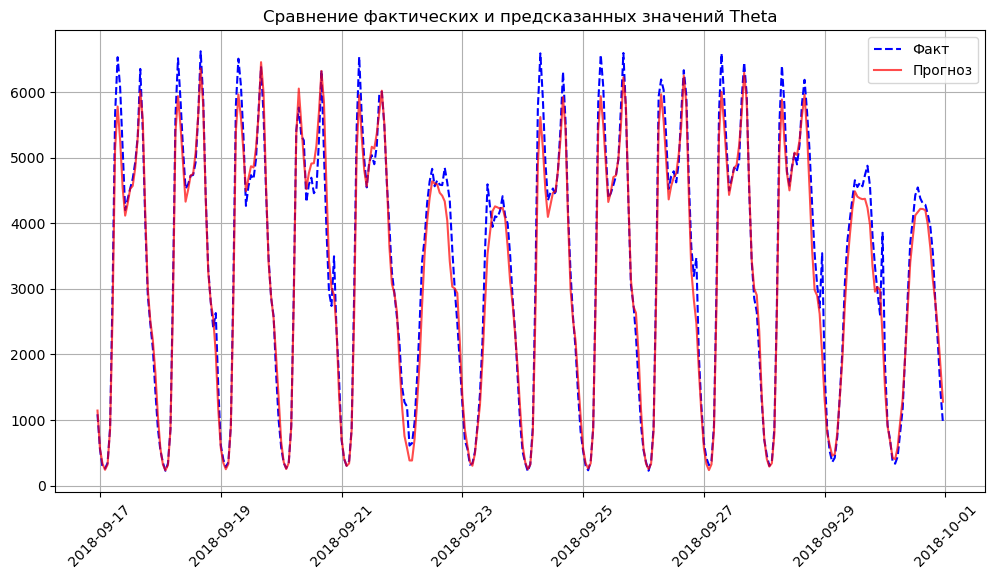

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data["traffic_volume"], label="Факт", color="blue", linestyle="dashed")
plt.plot(test_data.index, test_data[f"theta_prediction_{24*7*3}"], label="Прогноз", color="red", alpha=0.7)
plt.legend()
plt.title("Сравнение фактических и предсказанных значений Theta")
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Сравнение качества моделей

In [31]:
error_metrics

,Model,MAE,RMSE,MAPE
0,Baseline,207.620128,302.171565,9.321803
1,Random Forest,246.350844,392.834789,11.347446
2,XGBoost,204.923154,304.821383,9.973941
3,Theta (168 часов),237.260514,341.298184,9.084632
4,Theta (336 часов),226.895037,331.495209,8.471677
5,Theta (504 часов),221.612177,319.691418,8.347280
6,Theta (672 часов),233.832645,337.893885,9.371032


### Прогнозирование следующей за временным рядом недели на базе лучшей модели

In [32]:
forecast_steps = 24 * 7 # Укажем количество шагов для прогноза
theta_best = ThetaModel(train_data["traffic_volume"], period=forecast_steps).fit()
forecast = theta_best.forecast(forecast_steps)
forecast_dates = pd.date_range(start=test_data.index.max(), periods=forecast_steps + 1, freq="H")[1:]
forecast_df = pd.DataFrame({"date_time": forecast_dates, "forecast": forecast.values})

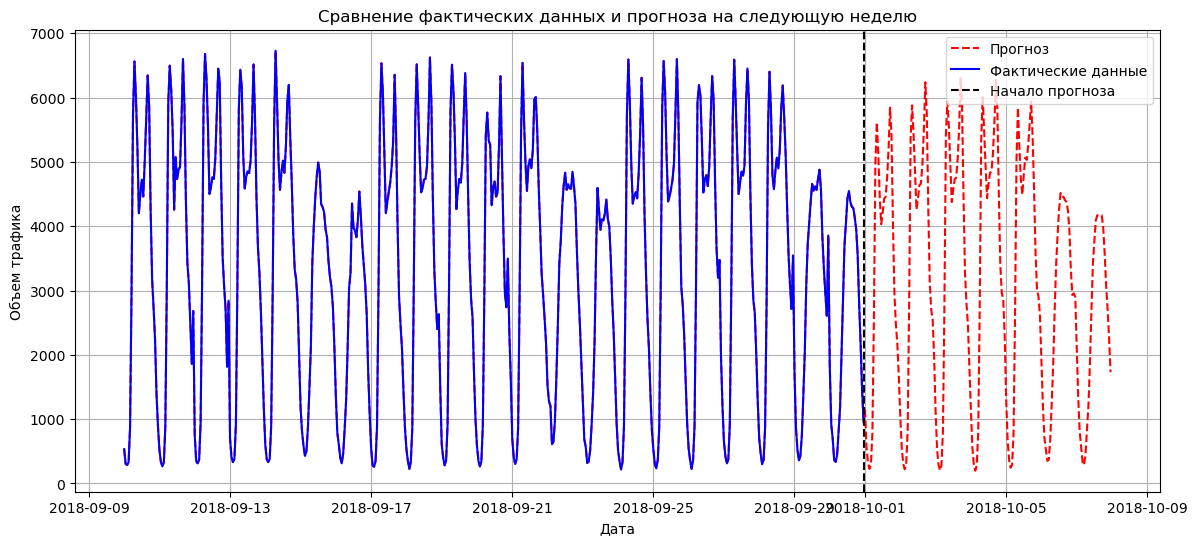

In [33]:
real_data = data.iloc[-24*7*3:].copy()  # Возьмём данные за последние 3 недели
real_data = real_data.set_index("date_time")
full_forecast_df = pd.concat([real_data[["traffic_volume"]].rename(columns={"traffic_volume": "forecast"}), 
                              forecast_df.set_index("date_time")])

plt.figure(figsize=(14, 6))
plt.plot(full_forecast_df.index, full_forecast_df["forecast"], label="Прогноз", linestyle="dashed", color="red")
plt.plot(real_data.index, real_data["traffic_volume"], label="Фактические данные", linestyle="solid", color="blue")
plt.axvline(x=real_data.index[-1], color="black", linestyle="--", label="Начало прогноза")
plt.title("Сравнение фактических данных и прогноза на следующую неделю")
plt.xlabel("Дата")
plt.ylabel("Объем трафика")
plt.legend()
plt.grid()
plt.show()